# <u> Preparing all the data needed </u>
## <b> Objectives: </b>
### Scraping economic data from the Federal Reserve Bank of St. Louis (FRED)
### Downloading the neccessary data from yahoo finance (yfinance)

In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from fredapi import Fred
import numpy as np
import os
from dotenv import load_dotenv

#start date
start="2015-01-01"

# Download data
data = yf.download(["GLD", "UUP", "^TNX", "^VIX", "^MOVE", "ZQ=F"], start=start)['Close']
# GLD is an etf that tracks the price of gold
# UUP is an etf that tracks the value of the US Dollar against a basker of major world currencies
# ^TNX is the risk-free rate of return on 10-year US government bonds
# ZQ=F is a futures contract reflecting market expectations for the Federal Reserve's official interest rate
# ^VIX measures the expected volatility in the S&P 500
# ^MOVE measures the expected volatility in US Treasury yields

load_dotenv()
api_key = os.getenv('FRED_API_KEY')
#Pull data from FRED using an api 
fred = Fred(api_key=api_key)

fed_balance_sheet = web.DataReader("WALCL", "fred",  start=start) #US federal reserve balance sheet
cpi = web.DataReader("CPIAUCSL", "fred", start=start) #US consumer price index
nfp = web.DataReader("PAYEMS", "fred", start=start) #US non-farm payrolls
gdp = web.DataReader("GDP", "fred", start=start) #US gross domestic product report
dff = web.DataReader("DFF", "fred", start=start) #US federal funds effective rate

#rename them 
fed_assets = fed_balance_sheet.rename(columns={'WALCL': 'Fed_Balance'}) 
cpi_data = cpi.rename(columns={'CPIAUCSL': 'CPI'})
nfp_data = nfp.rename(columns={'PAYEMS': 'NFP'})
gdp_data = gdp.rename(columns={'GDP': 'GDP'})
dff_data = dff.rename(columns={'DFF': 'DFF'})

# concatenate all of them into a single table 
df = pd.concat([data, fed_assets, cpi_data, nfp_data, gdp_data, dff_data], axis=1)

# This prevents look-ahead bias
df['NFP'] = df['NFP'].shift(25) # delay by 25 trading days
df['CPI'] = df['CPI'].shift(32) # delay by 32 trading days
df['GDP'] = df['GDP'].shift(85) # delay by 85 trading days
df['Fed_Balance'] = df['Fed_Balance'].shift(2) # delay by 2 trading days
df['DFF'] = df['DFF'].shift(1) # delay by 1 trading days
df = df.ffill().dropna() #forward fill and remove Not a Number (NaN)

[*********************100%***********************]  6 of 6 completed


# <u> Features and target </u>
## <b> Objective: </b>
### Creating the features and target for my model

In [2]:
#create a new features dataframe
features = pd.DataFrame(index=df.index) 

#macro momentum
features['Gold_Ret'] = df['GLD'].pct_change() #percentage change in the price of gold each day
features['USD_Ret'] = df['UUP'].pct_change()  #percentage change in the price of the USD index 
features['Real_Yield'] = df['^TNX'] - (df['CPI'].pct_change(252) * 100) # 10 Year US Government Treasury Yield - Inflation Rate
features['Liquidity_Impulse'] = np.log(df['Fed_Balance'] / df['Fed_Balance'].shift(20)) # We use log returns because balance sheet moves are exponentials during crises like 2008
features['Growth_Score'] = df['GDP'].pct_change(252) + df['NFP'].pct_change(252) #gives a rough inidicator of how well the US economy is doing
features['Expected_Rate_Change'] = (100 - df['ZQ=F']) - df['DFF'] #implied future rate - current rate

#percentage change in US non-farm payroll
nfp_change = df['NFP'].pct_change() 
nfp_change = nfp_change.replace(0, np.nan) #replace 0 with NaN(Not a Number)
features['NFP_Change'] = nfp_change.ffill() 

#stress and volatility
features['VIX_Level'] = df['^VIX'].pct_change() #percentage change in S&P 500 volatility
# Normalize (Z-Score or Ratio to Mean)
# This answers: "Is today's fear high relative to the last year?"
vix_norm = df['^VIX'] / df['^VIX'].rolling(252).mean() #calculate 1 year moving average 
move_norm = df['^MOVE'] / df['^MOVE'].rolling(252).mean()
# Positive Value = Bond Market is more scared than Stock Market (Liquidity Risk)
# Negative Value = Stock Market is more scared (Recession Risk)
features['Stress_Source'] = move_norm - vix_norm

# Technical Indicators
MA_50 = data['GLD'].rolling(50).mean() #calculate 50 days moving average
MA_200 = data['GLD'].rolling(200).mean() #calculate 200 days moving average
# This captures "Momentum" without being tied to a specific dollar price
features['Trend_Strength'] = MA_50 / MA_200
# Or Distance from Trend
features['Price_vs_MA200'] = data['GLD'] / MA_200

# Target Generation
# Predict if the 3-day future return is positive (smoother than 1-day)
threshold = 0.005 # This is represents 0.5% and is a noise filter.
features['Target'] = (df['GLD'].pct_change(3).shift(-3) > threshold).astype(int)
features.dropna(inplace=True)

# <u> Features and sets </u>
## <b> Objectives: </b>
### Grouping features into one data set and target into another data set 
### Cleaning the data 
### Split them into different sets for training 

In [3]:
# Define Features (X) and Target (y)
X = features[['USD_Ret', 'Gold_Ret', 'Real_Yield', 'Liquidity_Impulse', 'NFP_Change', 'Growth_Score', 'Expected_Rate_Change', 'VIX_Level', 'Stress_Source', 'Trend_Strength', 'Price_vs_MA200']]
y = features['Target']

# If I did not drop NaNs created by rolling windows, sklearn will throw an error
clean_data = pd.concat([X, y], axis=1).dropna()
X = clean_data[X.columns]
y = clean_data['Target']

# Split data
n = len(X)
train_end1 = int(0.5 * n)

X_train1 = X.iloc[:train_end1].copy()  # Part 1 of the split data used for permutation importance
y_train1 = y.iloc[:train_end1].copy()

X_train2 = X.iloc[train_end1:].copy()  # Part 2 of the split data used for permutation importance
y_train2 = y.iloc[train_end1:].copy()

X_train = X.copy()        # Combination of Part 1 and 2 data
y_train = y.copy()

# <u> Feature Selection via Permutation Importance Analysis </u>
## <b> Objectives: </b>
### To identify and rank the most predictive drivers within the quantitative model
### Measuring the degradation in Random Forest performance when individual input signals are randomized
### Isolating robust signals from noise


Feature Importance (Top is Best):
                 Feature  Importance_Mean  Importance_Std
4             NFP_Change         0.006220        0.002541
10        Price_vs_MA200         0.004593        0.001646
5           Growth_Score         0.003828        0.002305
0                USD_Ret         0.002871        0.001865
7              VIX_Level         0.002105        0.001116
1               Gold_Ret         0.001340        0.001367
6   Expected_Rate_Change         0.001244        0.001214
9         Trend_Strength         0.001053        0.002438
8          Stress_Source         0.000478        0.001229
3      Liquidity_Impulse         0.000096        0.001383
2             Real_Yield        -0.001914        0.001914


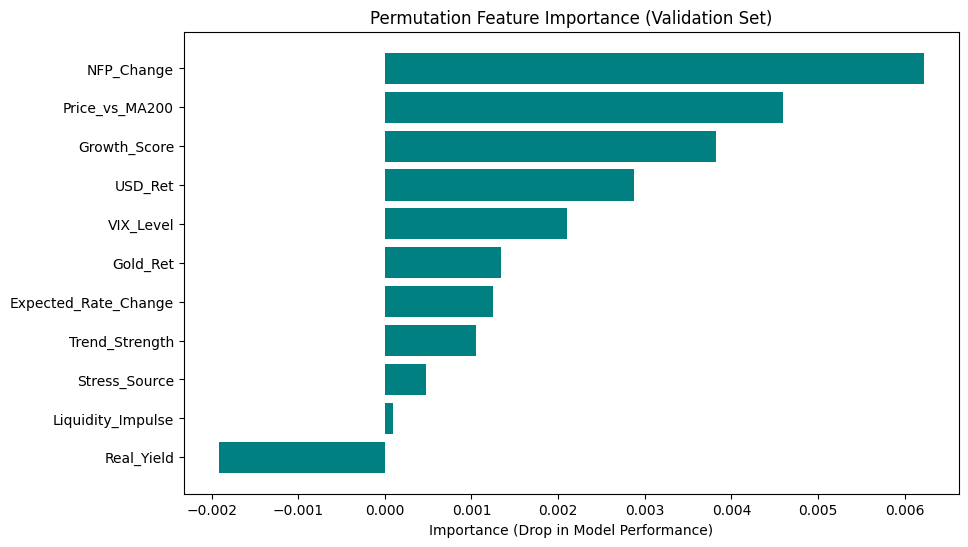

In [4]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# --- SECTION 1: Model Initialization and Training ---
# Initialize Random Forest to capture non-linear relationships in market data.
# n_estimators=100: Uses 100 trees to reduce variance.
# max_depth=5: Limits tree depth to prevent overfitting to noise.
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the model on the first training segment (e.g., the training fold).
model.fit(X_train1, y_train1)


# --- SECTION 2: Permutation Importance Calculation ---
# Calculate feature importance using a separate validation set (X_train2, y_train2).
# This measures how much the model's performance drops when a feature is randomly shuffled.
# Using a separate set prevents bias that occurs if we test importance on the same data used for training.
result = permutation_importance(
    model, 
    X_train2, 
    y_train2, 
    n_repeats=10,       # Shuffle each feature 10 times to smooth out random noise
    random_state=42,    # Ensures reproducibility of the shuffling
    n_jobs=-1           # Parallelize computation using all available CPU cores
)


# --- SECTION 3: Importance Metrics Compilation ---
# Organize raw results into a pandas DataFrame for analysis.
# 'importances_mean': The average drop in score (accuracy/R2) when the feature is corrupted.
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std  # Standard deviation helps assess stability of the importance
}).sort_values(by='Importance_Mean', ascending=False)

# Output the ranked features to console for quick verification.
print("\nFeature Importance (Top is Best):")
print(perm_df)


# --- SECTION 4: Visualization ---
# Plot a horizontal bar chart to visually compare feature contributions.
plt.figure(figsize=(10, 6))

# Create horizontal bars using the sorted DataFrame
plt.barh(perm_df['Feature'], perm_df['Importance_Mean'], color='teal')

plt.xlabel("Importance (Drop in Model Performance)")
plt.title("Permutation Feature Importance (Validation Set)")

# Invert y-axis so the most important feature appears at the top of the chart
plt.gca().invert_yaxis() 

plt.show()

# <u> Automated Feature Selection and Temporal Engineering </u>
## <b> Objectives: </b>
### Filter Valid Signals
### Engineer Time-Series Features
### Prepare New Dataset for the Interaction Features Function

In [5]:
# --- SECTION 1: Automated Feature Filtering ---
# Filter the results from the previous permutation analysis.
# Only kept features with an Importance_Mean > 0, discarding those that had no impact or a negative impact (noise) on model performance.
selected_features = perm_df[perm_df['Importance_Mean'] > 0].copy()

# Convert the filtered column names into a list for easy iteration.
feature_list = selected_features['Feature'].tolist()

# Output the count and details of the surviving features for verification.
print(f"Automatically selected {len(selected_features)} features:")
print(selected_features)


# --- SECTION 2: Time-Series Feature Engineering ---
# Create a new DataFrame containing only the high-quality features identified above.
df_to_engineer = X_train[feature_list].copy()

# Initialize a list to store the new engineered series before merging them.
# (Collecting in a list first is more efficient than repeatedly concatenating to a DataFrame).
new_features = []

# Loop through each valid feature to generate temporal derivatives.
for col in feature_list:
    # Lag 1: Captures the immediate previous value (Yesterday's value).
    lag1 = df_to_engineer[col].shift(1).rename(f'{col}_lag1') 
    
    # Lag 3: Captures the value from 3 steps ago (identifies short-term trend context).
    lag3 = df_to_engineer[col].shift(3).rename(f'{col}_lag3') 
    
    # Rate of Change (ROC): Calculates percentage change over 3 periods (Momentum).
    roc  = df_to_engineer[col].pct_change(3).rename(f'{col}_roc') 

    # Add these new series to our storage list.
    new_features.extend([lag1, lag3, roc])


# --- SECTION 3: Dataset Consolidation and Cleaning ---
# Concatenate the original selected features with the new engineered features.
# axis=1 ensures they are added as new columns.
df_to_engineer = pd.concat([df_to_engineer] + new_features, axis=1)

# Drop rows containing NaN values created by the shift/pct_change operations.
# (e.g., the first 3 rows will be empty due to lag3 and roc calculations).
df_to_engineer.dropna(inplace=True)

Automatically selected 10 features:
                 Feature  Importance_Mean  Importance_Std
4             NFP_Change         0.006220        0.002541
10        Price_vs_MA200         0.004593        0.001646
5           Growth_Score         0.003828        0.002305
0                USD_Ret         0.002871        0.001865
7              VIX_Level         0.002105        0.001116
1               Gold_Ret         0.001340        0.001367
6   Expected_Rate_Change         0.001244        0.001214
9         Trend_Strength         0.001053        0.002438
8          Stress_Source         0.000478        0.001229
3      Liquidity_Impulse         0.000096        0.001383


# <u> Correlation-Filtered Interaction Feature Function </u>
## <b> Objectives: </b>
### Expand Feature Space
### Validate Predictive Power
### Optimize Performance

In [6]:
import itertools

def create_interaction_features(df, selected_features, target_col, corr_threshold):
    # Generates non-linear interaction features (products and ratios) between pairs of inputs.
    # Only retains interactions that exceed a specified correlation threshold with the target.
    
    # --- SECTION 1: Initialization and Setup ---
    # Create a clean working copy containing only the relevant features and target.
    df_base = df[selected_features + [target_col]].copy()
    
    # Initialize lists to store valid engineered series and their names.
    # Collecting series in a list first is significantly faster than repeated DataFrame concatenation.
    new_features_data = []
    new_features_names = []
    
    # Generate all unique pairwise combinations of the selected features (nC2).
    pairs = list(itertools.combinations(selected_features, 2))
    print(f"Scanning {len(pairs)} pairs for correlations > {corr_threshold}...")
    
    
    # --- SECTION 2: Interaction Generation and Filtering ---
    for f1, f2 in pairs:
        # --- A. Product Interaction (Multiplicative Effects) ---
        # Captures scenarios where features amplify each other (e.g., Volume * Volatility).
        interaction_prod = df_base[f1] * df_base[f2]
        
        # Validation: Check if the new feature has significant predictive power (correlation).
        if abs(interaction_prod.corr(df_base[target_col])) >= corr_threshold:
            col_name = f"{f1}_x_{f2}"
            interaction_prod.name = col_name 
            new_features_data.append(interaction_prod)
            new_features_names.append(col_name)

        # --- B. Ratio Interactions (Relative Value) ---
        # Add a small epsilon to prevent DivisionByZero errors.
        epsilon = 1e-9
        
        # Ratio 1: f1 / f2 (e.g., Price / Earnings)
        interaction_div1 = df_base[f1] / (df_base[f2] + epsilon)
        # Sanitize data: Replace infinite values (caused by 0 division) with 0 to maintain numerical stability.
        interaction_div1 = interaction_div1.replace([np.inf, -np.inf], 0)
        
        if abs(interaction_div1.corr(df_base[target_col])) >= corr_threshold:
            col_name = f"{f1}_div_{f2}"
            interaction_div1.name = col_name
            new_features_data.append(interaction_div1)
            new_features_names.append(col_name)
            
        # Ratio 2: f2 / f1 (The inverse relationship)
        interaction_div2 = df_base[f2] / (df_base[f1] + epsilon)
        interaction_div2 = interaction_div2.replace([np.inf, -np.inf], 0)
        
        if abs(interaction_div2.corr(df_base[target_col])) >= corr_threshold:
            col_name = f"{f2}_div_{f1}"
            interaction_div2.name = col_name
            new_features_data.append(interaction_div2)
            new_features_names.append(col_name)


    # --- SECTION 3: Aggregation and Output ---
    print(f"Found {len(new_features_names)} valid interactions.")
    
    if new_features_data:
        # Optimization: Perform a single batch concatenation to avoid memory fragmentation and optimize performance
        df_enhanced = pd.concat([df_base] + new_features_data, axis=1)
    else:
        # Fallback if no interactions met the correlation threshold.
        df_enhanced = df_base

    return df_enhanced, new_features_names

# <u> Dataset Alignment, Sanitization, and Final Feature Synthesis </u>
## <b> Objectives: </b>
### Synchronize Data
### Ensure Numerical Robustness
### Finalize Feature Set

In [7]:
# --- SECTION 1: Target-Feature Index Alignment ---
# Ensured the target variable (y_train) matches the rows of the engineered features.
# This is critical because previous steps (like lagging) may have dropped rows (NaNs), creating a mismatch in dataset lengths.
if len(df_to_engineer) != len(y_train):
    print("Aligning target to features...")
    # Filter y_train to only include indices present in the engineered feature set
    y_train_aligned = y_train.loc[df_to_engineer.index]
else:
    y_train_aligned = y_train


# --- SECTION 2: Data Consolidation and Sanitization ---
# Reset indices to a standard range (0 to N) to allow for safe concatenation without index collision errors.
train_full = df_to_engineer.reset_index(drop=True).copy()

# Added the aligned target to the dataset for correlation checks in the next step.
train_full['target'] = y_train_aligned.reset_index(drop=True)

# Cleaned numerical instabilities:
# 1. Replaced infinite values (from division by zero) with 0.
train_full = train_full.replace([np.inf, -np.inf], 0)
# 2. Filled missing values with 0 to ensure model compatibility.
train_full = train_full.fillna(0)

# Remove "Zero Variance" features:
# Dropped columns where all values are identical (constant), as they provide no predictive signal.
non_constant_cols = train_full.loc[:, (train_full != train_full.iloc[0]).any()].columns
train_full = train_full[non_constant_cols]


# --- SECTION 3: Advanced Interaction Generation ---
# Defined the list of inputs to be crossed, explicitly excluding the target variable.
feature_list_expanded = [c for c in df_to_engineer.columns if c != 'target']

# Executed the custom interaction function to generate second-order features.
# A threshold of 0.02 ensures we only keep interactions with at least 2% correlation to target.
df_final, _ = create_interaction_features(
    train_full, 
    feature_list_expanded, 
    target_col='target', 
    corr_threshold=0.02
)


# --- SECTION 4: Final Dataset Preparation ---
# Segregate the features from the target to create the final training matrix (X_train_final).
X_train_final = df_final.drop(columns=['target'])

# Output the final dimensionality of the model input to verify feature expansion.
print(f"Final Feature Count: {X_train_final.shape[1]}")

Aligning target to features...
Scanning 780 pairs for correlations > 0.02...
Found 1135 valid interactions.
Final Feature Count: 1175


# <u> Multicollinearity Reduction via Hierarchical Clustering </u>
## <b> Objectives: </b>
### Identify Redundancy
### Determine Structure
### Curate Efficient Inputs


--- Step 1: Hierarchical Clustering ---


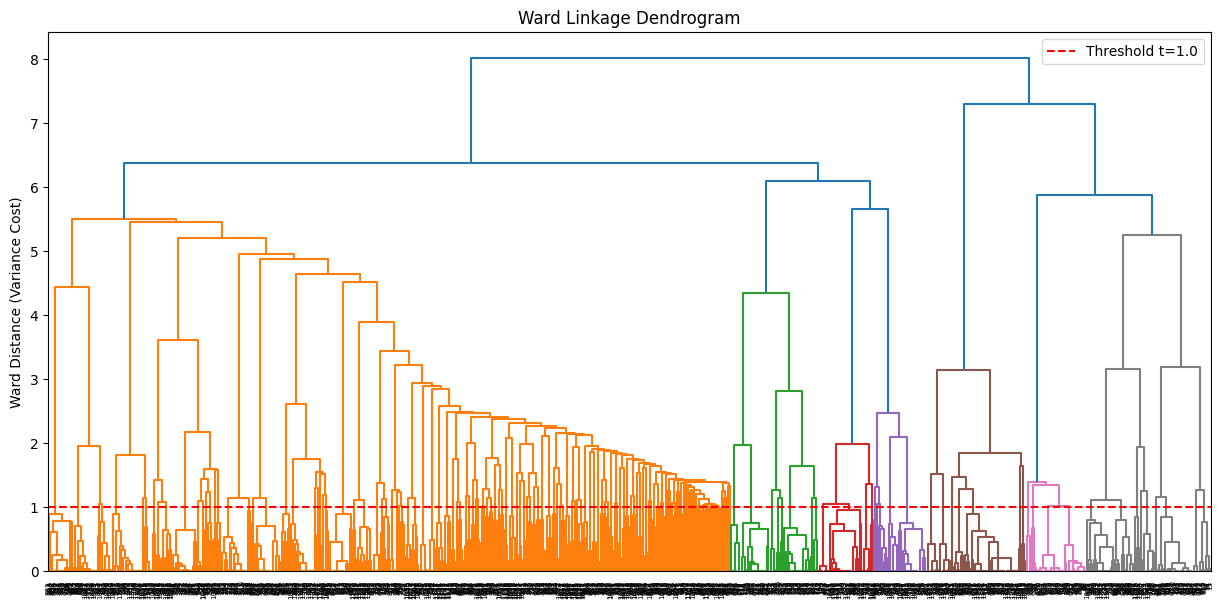

Features Remaining after Clustering: 172
Any of the features above the red line would be kept.


In [8]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Define inputs
X = X_train_final
Y = y_train_aligned

# --- SECTION 1: Similarity Measurement ---
print("\n--- Step 1: Hierarchical Clustering ---")

# 1. Calculate Spearman Rank Correlation.
# Chosen over Pearson because it captures monotonic (non-linear) relationships and is robust to outliers, which is critical for financial data.
corr = spearmanr(X).correlation

# Ensure the matrix is perfectly symmetric to avoid numerical errors in clustering.
corr = (corr + corr.T) / 2
# Fill diagonal with 1.0 (self-correlation) to ensure mathematical validity.
np.fill_diagonal(corr, 1)

# 2. Convert Correlation to Distance.
# Distance = 1 - |Correlation|.
# High correlation (near 1 or -1) results in a distance near 0 (features are "close").
# Low correlation (near 0) results in a distance near 1 (features are "far").
distance_matrix = 1 - np.abs(corr)


# --- SECTION 2: Hierarchical Linkage and Visualization ---
# Perform Ward's Linkage:
# This minimizes the variance of the clusters being merged. It is generally effective at creating compact, even-sized clusters.
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# Define the cut-off threshold (t).
# t=1 implies we treat features as separate if their distance > 1.
# Adjusting this value controls the aggressiveness of the feature reduction.
t_value = 1

# Plot Dendrogram (Tree Diagram)
# Visualizes how features merge into clusters. The height of the U-shape links represents the "distance" between the merged groups.
plt.figure(figsize=(15, 7))
dendro = hierarchy.dendrogram(
    dist_linkage,
    no_plot=False,
    labels=None,    # Labels suppressed for clarity if feature count is high
    leaf_rotation=90
)

# Draw the cut-off line to visually verify where clusters are formed.
plt.axhline(y=t_value, color='r', linestyle='--', label='Threshold t=1.0')
plt.title('Ward Linkage Dendrogram')
plt.ylabel('Ward Distance (Variance Cost)')
plt.legend()
plt.show()


# --- SECTION 3: Redundancy Elimination ---
# 3. Assign features to clusters based on the threshold `t`.
# Features in the same cluster are considered collinear/redundant.
cluster_ids = hierarchy.fcluster(dist_linkage, t=t_value, criterion="distance")

# 4. Select One Representative Feature per Cluster.
# Strategy: Instead of picking randomly, we pick the feature within each cluster that has the highest individual correlation with the target (Y).
cluster_to_feat = {}
for feat_idx, clust_id in enumerate(cluster_ids):
    if clust_id not in cluster_to_feat:
        cluster_to_feat[clust_id] = []
    cluster_to_feat[clust_id].append(feat_idx)

kept_features_idx = []
# Iterate through each identified cluster
for clust_id, feat_indices in cluster_to_feat.items():
    # Find the 'best' feature in the group (highest abs correlation with target)
    best_feat = max(feat_indices, key=lambda i: abs(spearmanr(X.iloc[:, i], Y)[0]))
    kept_features_idx.append(best_feat)

# Subset the original dataset to keep only the selected representatives.
X_cluster = X.iloc[:, kept_features_idx]
print(f"Features Remaining after Clustering: {X_cluster.shape[1]}")
print("Any of the features above the red line would be kept.")

# <u> Noise Reduction via Permutation Importance </u>
## <b> Objectives: </b>
### Validate Feature Utility
### Enhance Model Robustness
### Optimize Dimensionality

In [9]:
# --- SECTION 1: Probe Model Initialization ---
print("\n--- Step 2: Permutation Importance ---")

# Initialize a "Probe" Random Forest.
# This model is not the final predictor; its sole purpose is to learn the data structure so we can test which features are actually relied upon for accuracy.
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Train the probe model on the post-clustering dataset.
rf.fit(X_cluster, Y)


# --- SECTION 2: Stochastic Importance Evaluation ---
# Calculate Permutation Importance.
# This shuffles each feature column one by one and measures the drop in the model's score.
# n_repeats=5: Performs the shuffle 5 times per feature to average out variance.
# n_jobs=10: Utilizes 10 CPU cores for parallel processing (adjust based on hardware).
result = permutation_importance(rf, X_cluster, Y, n_repeats=5, random_state=42, n_jobs=10)


# --- SECTION 3: Signal-to-Noise Filtering ---
# Consolidate feature names and their corresponding mean importance scores.
perm_imp_df = pd.DataFrame({
    'feature': X_cluster.columns,
    'importance': result.importances_mean
})

# Filter Logic: Keep only features with Importance > 0.
# Importance > 0: The feature contributes signal; removing it hurts performance.
# Importance <= 0: The feature is noise; the model performed the same (or better) without it.
selected_feats_perm = perm_imp_df[perm_imp_df['importance'] > 0]['feature'].tolist()

# Create the reduced dataset containing only the validated features.
X_perm = X_cluster[selected_feats_perm]


# --- SECTION 4: Final Selection Output ---
# Output statistics to verify the severity of the cut.
print(f"Number of Features Remaining: {len(X_perm.columns)}")
print("Top 10 Features:", X_perm.columns[:10].tolist())

# Create the final variable for the next pipeline stage.
X_final = X_perm.copy()


--- Step 2: Permutation Importance ---
Number of Features Remaining: 2
Top 10 Features: ['Price_vs_MA200_lag3_div_Trend_Strength_roc', 'Liquidity_Impulse_lag1_div_Liquidity_Impulse']


# <u> Data Splitting and Class Balancing for XGBoost </u>
## <b> Objectives: </b>
### Preserve Temporal Order
### Align Input/Output
### Optimize for Imbalance

In [10]:
# --- SECTION 1: Final Dataset Synchronization ---
# Critical Check: Ensure the feature matrix (X_final) and target vector (y_train_aligned) have the exact same number of observations before splitting.
# Mismatches here will cause the model training to fail or learn incorrect mappings.
if len(X_final) != len(y_train_aligned):
    print("Aligning target to features...")
    # Re-align the target variable to match the indices of the cleaned feature set.
    # Note: Using df_to_engineer.index assumes X_final retained the original index.
    y_train_aligned2 = y_train_aligned.loc[X_final.index]
else:
    y_train_aligned2 = y_train_aligned


# --- SECTION 2: Time-Series Split (Walk-Forward) ---
# Define the boundary between Training data (Past) and Testing data (Future).
# We use an 80/20 split. Unlike random splitting (K-Fold), we slice strictly by time index
# to prevent "Look-Ahead Bias" (training on future data to predict the past).
split_index = int(len(X_final) * 0.80)

# Create the Training Set (First 80% of chronological data).
# This is the data the XGBoost model will actually learn from.
X_train_split = X_final.iloc[:split_index]
y_train_split = y_train_aligned2.iloc[:split_index]

# Create the Testing Set (Last 20% of chronological data).
# This serves as the "Out-of-Sample" validation to simulate live trading performance.
X_test_split = X_final.iloc[split_index:]
y_test_split = y_train_aligned2.iloc[split_index:]

# Output the split sizes to verify we have enough data in both sets.
print(f"Training on {len(X_train_split)} rows.")
print(f"Testing on {len(X_test_split)} rows.")


# --- SECTION 3: Class Imbalance Calculation for XGBoost ---
# Calculate the ratio of Negative cases (0) to Positive cases (1).
# n_pos: Number of times the target event occurred (e.g., price went UP).
# n_neg: Number of times the target event did NOT occur.
n_pos = y_train_split.sum()
n_neg = len(y_train_split) - n_pos

# Calculate 'scale_pos_weight'.
# This ratio will be passed to the XGBoost `scale_pos_weight` parameter.
# It forces the model to pay more attention to the minority class, preventing it from simply predicting the majority class all the time.
scale_ratio = n_neg / n_pos

Training on 1664 rows.
Testing on 416 rows.


# <u> XGBoost Model Initialization and Robust Training </u>
## <b> Objectives: </b>
### Configure for Low Variance
### Automate Convergence
### Rectify Class Imbalance

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier

# --- SECTION 1: Hyperparameter Specification & Initialization ---
# Initialize the Gradient Boosting Classifier with a focus on regularization.
# Financial data is noisy; these parameters are chosen to prevent "memorizing" that noise.
model = XGBClassifier(
    n_estimators=1000,        # Maximum potential trees. This is high because Early Stopping will limit it.
    learning_rate=0.01,       # "Shrinkage": Low rate requires more trees but generalizes better (Slow & Steady).
    max_depth=3,              # Constrain tree depth. Shallow trees (stumps) capture broad trends; deep trees overfit.
    subsample=0.7,            # Stochastic Gradient Boosting: Use only 70% of data rows per iteration (reduces variance).
    colsample_bytree=0.7,     # Feature Subsampling: Use only 70% of features per tree (forces model to find new signals).
    n_jobs=-1,                
    random_state=42,          # Ensures the random subsampling is reproducible.
    objective='binary:logistic', # Standard objective function for binary classification (Buy vs. No-Buy).
    eval_metric='logloss',    # The error metric to minimize. Logloss penalizes confident wrong answers heavily.
    early_stopping_rounds=50, # Critical for Time-Series: Stop training if validation score doesn't improve for 50 rounds.
    scale_pos_weight=scale_ratio # Inject the previously calculated ratio to handle class imbalance (Few buys, many holds).
)


# --- SECTION 2: Walk-Forward Training with Validation ---
# Define the evaluation set used to monitor performance during training.
# Monitor both Training error (to check learning) and Test error (to check generalization).
eval_set = [(X_train_split, y_train_split), (X_test_split, y_test_split)]

# Execute the training process.
model.fit(
    X_train_split, 
    y_train_split,
    eval_set=eval_set,        # Pass the validation data for early stopping monitoring.
    verbose=50                # Logging: Report the training/testing error every 50 iterations to keep the console clean.
)

[0]	validation_0-logloss:0.69260	validation_1-logloss:0.69292
[50]	validation_0-logloss:0.67888	validation_1-logloss:0.68463
[100]	validation_0-logloss:0.66833	validation_1-logloss:0.68085
[150]	validation_0-logloss:0.66125	validation_1-logloss:0.67957
[200]	validation_0-logloss:0.65543	validation_1-logloss:0.67918
[250]	validation_0-logloss:0.65102	validation_1-logloss:0.67870
[300]	validation_0-logloss:0.64724	validation_1-logloss:0.67964
[301]	validation_0-logloss:0.64709	validation_1-logloss:0.67965


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.7
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_method=

# <u> Dynamic Evaluation and Visual Interpretation </u>
## <b> Objectives: </b>
### Calibrate Sensitivity
### Quantify Ranking Quality
### Audit Model Logic

Dynamic Threshold Used: 0.5734
Adjusted Accuracy:      65.14%
AUC Score:              0.5806 (Above 0.50 means it has found a signal)

Confusion Matrix:
 [[246  35]
 [110  25]]


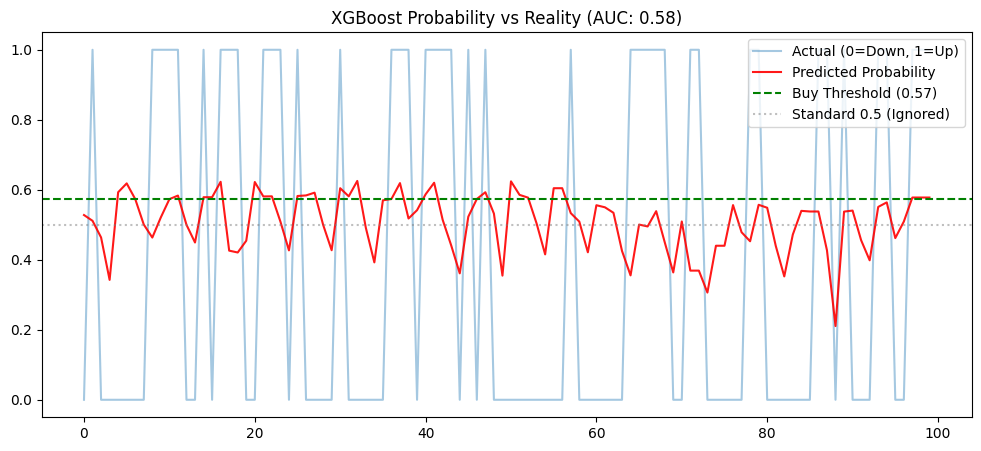

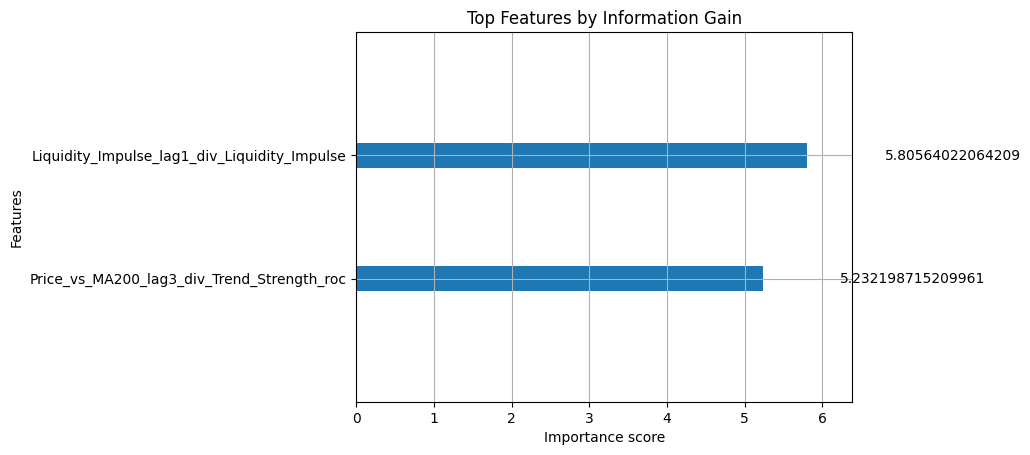

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# --- SECTION 1: Dynamic Thresholding & Metric Calculation ---
# Generate raw probability scores for the Positive class (1).
# Use probabilities instead of hard predictions to allow for custom thresholding.
preds_proba = model.predict_proba(X_test_split)[:, 1]

# Calibrate the "Buy" Threshold:
# Calculate the 85th percentile score to force the model to trade only the top 15% of its strongest ideas.
dynamic_threshold = np.percentile(preds_proba, 85)

# Generate Hard Predictions:
# Convert probabilities into binary signals (1 or 0) using a custom dynamic threshold.
preds_hard = [1 if p > dynamic_threshold else 0 for p in preds_proba]

# Calculate Performance Metrics:
# Accuracy: Percentage of correct predictions (can be misleading in imbalanced data).
# AUC (Area Under Curve): Measures the model's ability to rank winners higher than losers. 
# AUC is generally preferred over accuracy for financial models; >0.5 implies edge.
acc = accuracy_score(y_test_split, preds_hard)
auc = roc_auc_score(y_test_split, preds_proba) 

# Output the results for analysis.
print(f"Dynamic Threshold Used: {dynamic_threshold:.4f}")
print(f"Adjusted Accuracy:      {acc*100:.2f}%")
print(f"AUC Score:              {auc:.4f} (Above 0.50 means it has found a signal)")
print("\nConfusion Matrix:\n", confusion_matrix(y_test_split, preds_hard))


# --- SECTION 2: Visual Performance Analysis ---
# Plot 1: Probability vs. Reality (Zoomed View)
plt.figure(figsize=(12, 5))

# Subset the last 100 periods to visually inspect the most recent model behavior.
subset_y = y_test_split.values[-100:]
subset_preds = preds_proba[-100:]

# Plot actual market direction vs. Model confidence.
plt.plot(subset_y, label='Actual (0=Down, 1=Up)', alpha=0.4)
plt.plot(subset_preds, label='Predicted Probability', color='red', alpha=0.9)

# Visualizing the Decision Boundary:
# Draw the "Green Line" (Dynamic Threshold) to show exactly where the model triggers a buy.
# Draw the "Grey Line" (Standard 0.5) to show why the standard threshold would have failed (likely too high).
plt.axhline(dynamic_threshold, color='green', linestyle='--', label=f'Buy Threshold ({dynamic_threshold:.2f})')
plt.axhline(0.5, color='grey', linestyle=':', alpha=0.5, label='Standard 0.5 (Ignored)')

plt.title(f'XGBoost Probability vs Reality (AUC: {auc:.2f})')
plt.legend(loc='upper right')
plt.show()


# --- SECTION 3: Interpretable Feature Importance ---
# Plot 2: Feature Contribution
# Importance Type = 'gain':
# 'Weight' (default) only counts how often a feature is used.
# 'Gain' measures the average improvement in accuracy brought by a feature. 
# Gain is the superior metric for identifying true predictive drivers.
xgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Top Features by Information Gain')
plt.show()

# <u> Robust Data Restoration and Alignment </u>
## <b> Objectives: </b>
### Recover Date Context
### Prepare for Backtest
### Map Returns to Signals

In [13]:
# ==============================================================================
# SECTION 1: Walk-Forward Simulation Setup
# ==============================================================================

# --- SECTION 1: Backtest Parameterization ---
# Define parameters for the rolling window backtest.
# window_size: 500 days (~2 years). The model trains on this moving window to adapt to
# recent market regimes (preventing "concept drift").
window_size = 500  

# step_size: 5 days. The model predicts the next week, then retraining occurs.
step_size = 5      

# The model trades only when its probability score is in the top 40% of the training set's distribution (100 - 60 = 40).
percentile_threshold = 60 

# Initialize containers to store simulation results for post-analysis.
results_signals = []        # Binary trading decision (1 = Holding, 0 = Cash)
results_probs = []          # Raw probability scores (0.0 - 1.0) for detailed analysis
results_thresholds = []     # The dynamic threshold value used for that specific batch
actual_returns_list = []    # The actual market return for PnL calculation
prediction_dates = []       # Dates to map predictions back to the calendar


# --- SECTION 2: Dataset Re-Instantiation and Integrity Check ---
# 1. RELOAD: Create a fresh copy of the final feature set.
# This ensures we aren't working with a modified/corrupted version from previous cells.
print("Restoring data from X_final...")
X_rolling = X_final.copy()
y_rolling = y_train_aligned2.copy()

# Critical Safety Check: Verify that the upstream data splitting actually worked.
# If X_rolling is empty or near-empty, the backtest will crash immediately.
if len(X_rolling) <= 1:
    print(f"CRITICAL WARNING: X_final only has {len(X_rolling)} rows!")
    print("You may need to re-run your Train/Test Split code upstream.")
else:
    print(f"Restored X_rolling with {len(X_rolling)} rows.")

    # 2. ALIGNMENT STRATEGY: "Tail Match"
    # Logic: X_rolling (cleaned data) is often shorter than the raw 'features' dataframe because of dropna() operations. We assume X_rolling represents the *most recent* data.
    # Therefore, we take the matching number of dates from the END of the original index.
    
    required_len = len(X_rolling)
    available_dates = features.index
    
    print(f"Aligning {required_len} rows of data to the last {required_len} dates from features...")
    
    # Slice the original datetime index to get the exact dates corresponding to our clean data.
    correct_dates = available_dates[-required_len:]
    

    # --- SECTION 3: Chronological Synchronization ---
    # 3. FORCE ASSIGN THE DATES
    # Replace the numeric index (0, 1, 2...) with the actual calendar dates.
    X_rolling.index = correct_dates
    y_rolling.index = correct_dates
    
    # 4. GET CORRESPONDING RETURNS
    # Fetch the 'Gold_Ret' (Market Return) for these exact dates.
    # This ensures accurate PnL calculation (matching prediction to reality).
    market_returns = features.loc[correct_dates, 'Gold_Ret'].copy()
    
    # 5. CLEANUP (Standardization)
    # Normalize timestamps to midnight (00:00:00) to ensure strict equality matching.
    # This prevents mismatches like "2024-01-01 09:30" != "2024-01-01 00:00".
    X_rolling.index = X_rolling.index.normalize()
    market_returns.index = market_returns.index.normalize()
    
    # Fill missing returns with 0.0 to prevent mathematical errors in cumulative product calcs.
    market_returns = market_returns.fillna(0.0)


    # --- SECTION 4: Pre-Run Verification ---
    # Print a summary to visually confirm the data range covers the expected period.
    print("\n--- RESTORATION COMPLETE ---")
    print(f"Start Date: {X_rolling.index[0]}")
    print(f"End Date:   {X_rolling.index[-1]}")
    print(f"Rows:       {len(X_rolling)}")
    print(f"Returns:    {len(market_returns)}")
    
    # Final logical check before allowing the loop to proceed.
    if len(X_rolling) == len(market_returns):
        print("SUCCESS: Data is aligned. You can now run the loop.")
    else:
        print("ERROR: Mismatch persists.")

Restoring data from X_final...
Restored X_rolling with 2080 rows.
Aligning 2080 rows of data to the last 2080 dates from features...

--- RESTORATION COMPLETE ---
Start Date: 2015-12-17 00:00:00
End Date:   2025-01-08 00:00:00
Rows:       2080
Returns:    2080
SUCCESS: Data is aligned. You can now run the loop.


# <u> Rolling Window Walk-Forward Analysis </u>
## <b> Objectives: </b>
### Simulate Time
### Adapt to Regimes
### Consolidate History

In [14]:
from IPython.display import display

# --- SECTION 1: Rolling Model Initialization ---
# Initialize a fresh instance of the classifier.
# Note: 'early_stopping_rounds' is set to None here because splitting a small rolling window into further validation sets can be unstable. 
# We rely on the robust hyperparameters set earlier.
rolling_model = XGBClassifier(
    n_estimators=1000,        
    learning_rate=0.01,       
    max_depth=3,              
    subsample=0.7,            
    colsample_bytree=0.7,     
    n_jobs=-1,          
    random_state=42,
    objective='binary:logistic', 
    eval_metric='logloss',    
    early_stopping_rounds=None, 
    scale_pos_weight=scale_ratio
)

print(f"Starting Rolling Backtest on {len(X_rolling)} rows...")


# --- SECTION 2: Walk-Forward Loop ---
# Iterate through the dataset using a sliding window approach.
# range(start, stop, step): Moves the window forward by 'step_size' (5 days) in each iteration.
for i in range(window_size, len(X_rolling), step_size):
    
    # --- A. Window Slicing (Train vs Test) ---
    # Define the Training Window (The "Past"):
    # Takes the previous 500 days (window_size) leading up to the current day 'i'.
    start_idx = i - window_size
    end_idx = i
    
    X_train_roll = X_rolling.iloc[start_idx:end_idx]
    y_train_roll = y_rolling.iloc[start_idx:end_idx]
    
    # Define the Test Window (The "Future"):
    # Takes the next 5 days (step_size) starting from 'i'.
    X_test_roll = X_rolling.iloc[end_idx : end_idx + step_size]
    
    # Safety Check: Stop if we run out of data at the end of the dataframe.
    if X_test_roll.empty:
        break

    # --- B. Model Training ---
    # Re-fit the model entirely on the current window's data.
    # This ensures the model adapts to the most recent market regime.
    rolling_model.fit(X_train_roll, y_train_roll, verbose=False)

    # --- C. Adaptive Thresholding ---
    # Calculate the probability distribution *specifically* for this training window.
    # Market volatility changes; a 0.7 probability in 2020 might mean something different in 2024.
    train_probs = rolling_model.predict_proba(X_train_roll)[:, 1]
    
    # Dynamically determine the cutoff to trade only the top 40% of signals in this specific regime.
    dynamic_cutoff = np.percentile(train_probs, percentile_threshold)

    # --- D. Prediction & Signal Generation ---
    # Predict probabilities for the 5 'future' days.
    test_probs = rolling_model.predict_proba(X_test_roll)[:, 1]
    
    # Generate binary signals: Buy (1) only if confidence exceeds the calculated dynamic cutoff.
    batch_signals = (test_probs > dynamic_cutoff).astype(int)

    # --- E. Result Aggregation ---
    # Append predictions and dates to the master lists.
    results_signals.extend(batch_signals)
    prediction_dates.extend(X_test_roll.index)
    
    # Retrieve and store the actual market returns for these specific test days to calculate PnL later.
    batch_returns = market_returns.iloc[end_idx : end_idx + step_size]
    actual_returns_list.extend(batch_returns)


# --- SECTION 3: Final Data Compilation ---
# Structure the results into a clean DataFrame indexed by date.
# This format allows for easy plotting of Equity Curves and calculating Sharpe Ratios.
backtest_df = pd.DataFrame({
    'Signal': results_signals,
    'Gold_Return': actual_returns_list,
}, index=prediction_dates)

print("Backtest Complete. Preview:")
display(backtest_df.tail())

Starting Rolling Backtest on 2080 rows...
Backtest Complete. Preview:


,Signal,Gold_Return
2025-01-02,1,0.013588
2025-01-03,0,-0.007864
2025-01-06,1,-0.001232
2025-01-07,1,0.005633
2025-01-08,1,0.005316


# <u> Performance Attribution and Equity Curve Visualization </u>
## <b> Objectives: </b>
### Quantify Sharpe
### Assess Reliability
### Normalize Risk


FINAL BACKTEST RESULTS
Market Return:      65.29%
Strategy Return:    60.59%
----------------------------------------
Market Sharpe:      0.63
Strategy Sharpe:    0.89
----------------------------------------
Trades Taken:       647 days (40.9% of time)
Win Rate:           56.4%


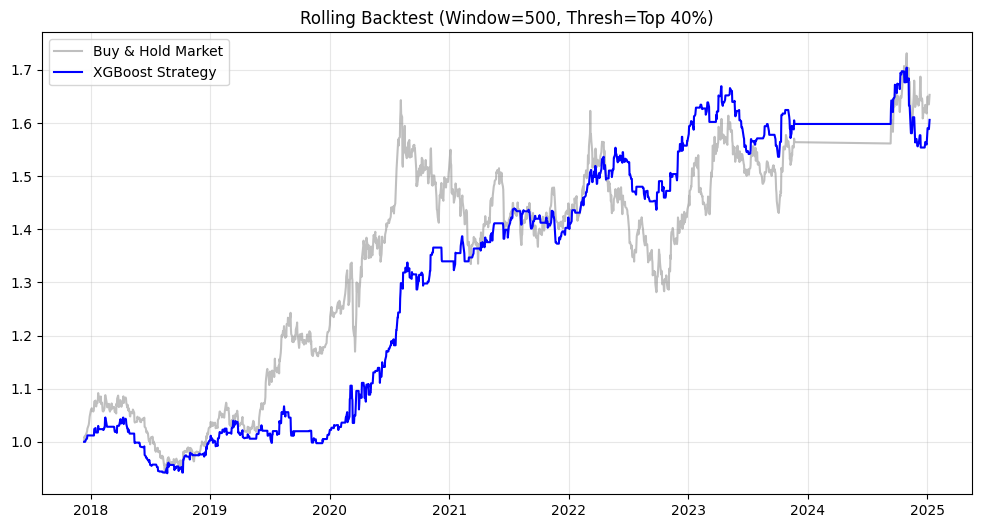

In [15]:
# --- SECTION 1: PnL Vectorization and Compounding ---
# Calculate Daily Strategy Returns:
# If Signal is 1 (Buy), we get the 'Gold_Return'. 
# If Signal is 0 (Cash), the return is 0.
backtest_df['Strategy_Return'] = backtest_df['Signal'] * backtest_df['Gold_Return']

# Calculate Cumulative Returns (Equity Curves):
# Use (1 + r).cumprod() to simulate the growth of a $1 investment over time.
# This accounts for the compounding effect of returns.
backtest_df['Cumulative_Market'] = (1 + backtest_df['Gold_Return']).cumprod()
backtest_df['Cumulative_Strategy'] = (1 + backtest_df['Strategy_Return']).cumprod()


# --- SECTION 2: Risk-Adjusted Performance Metrics ---
# A. Total Return (Absolute Performance)
# Measures the percentage change from the start to the end of the backtest.
total_strat_ret = backtest_df['Cumulative_Strategy'].iloc[-1] - 1
total_market_ret = backtest_df['Cumulative_Market'].iloc[-1] - 1

# B. Win Rate (Accuracy of Active Trades)
# Filter only for days where the model took a position (Signal == 1).
trades_df = backtest_df[backtest_df['Signal'] == 1]

if len(trades_df) > 0:
    # Win Rate = (Profitable Trades / Total Trades) * 100
    win_rate = (trades_df['Strategy_Return'] > 0).sum() / len(trades_df) * 100
else:
    win_rate = 0

# C. Sharpe Ratio (Risk-Adjusted Return)
# Annualization Factor N = 252 (Typical trading days in a year).
# Formula: (Mean Daily Return / Std Dev of Daily Returns) * sqrt(252).
# This penalizes strategies that have high returns but extreme volatility.
N = 252 

strat_mean = backtest_df['Strategy_Return'].mean()
strat_std = backtest_df['Strategy_Return'].std()

# Safety check to prevent division by zero if flat.
if strat_std > 0:
    sharpe_strategy = (strat_mean / strat_std) * (N ** 0.5)
else:
    sharpe_strategy = 0.0

# Calculate Benchmark Sharpe for comparison
market_mean = backtest_df['Gold_Return'].mean()
market_std = backtest_df['Gold_Return'].std()
sharpe_market = (market_mean / market_std) * (N ** 0.5)


# --- SECTION 3: Benchmarking and Visual Reporting ---
# Print a consolidated summary to the console for quick validation.
print("\n" + "="*40)
print("FINAL BACKTEST RESULTS")
print("="*40)
print(f"Market Return:      {total_market_ret*100:.2f}%")
print(f"Strategy Return:    {total_strat_ret*100:.2f}%")
print("-" * 40)
print(f"Market Sharpe:      {sharpe_market:.2f}")
print(f"Strategy Sharpe:    {sharpe_strategy:.2f}")
print("-" * 40)
print(f"Trades Taken:       {len(trades_df)} days ({len(trades_df)/len(backtest_df)*100:.1f}% of time)")
print(f"Win Rate:           {win_rate:.1f}%")

# Visualization: Equity Curve Comparison
plt.figure(figsize=(12, 6))

# Plot the Benchmark (Passive Holding) in Grey
plt.plot(backtest_df.index, backtest_df['Cumulative_Market'], label='Buy & Hold Market', color='grey', alpha=0.5)

# Plot the Active Strategy in Blue to highlight outperformance/underperformance
plt.plot(backtest_df.index, backtest_df['Cumulative_Strategy'], label='XGBoost Strategy', color='blue', linewidth=1.5)

plt.title(f"Rolling Backtest (Window={window_size}, Thresh=Top {100-percentile_threshold}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()